<a href="https://colab.research.google.com/github/aneeshnema/unusual-activity-detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unusal activity detection using Convolutional Auto Encoder by Learning Temporal Regularity

In [ ]:
!pip install pytorch-lightning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# root folder location where to store datasets, models
path="/content/drive/My Drive/uad"

## Import Libraries

In [4]:
import glob
import numpy as np
from requests import get
import tarfile
import os
from PIL import Image
import h5py
# from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adagrad
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Dataset Generation

note: only ucsdped1 and ucsdped2 are used for training and the dataset only consists of stacked frames with stride 1

In [ ]:
def generate_dataset(path):
  # path: folder location where to store hdf5 datasets
  def check_raw(path):
    rawdatapath = os.path.join(path, "UCSD_Anomaly_Dataset.v1p2")
    if not os.path.isdir(rawdatapath):
      tarpath = os.path.join(path, "UCSD_Anomaly_Dataset.tar.gz")
      if not os.path.isfile(tarpath):
        print('Downloading Dataset...')
        r = get("http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz", allow_redirects=True)
        open(tarpath, 'wb').write(r.content)
      print('Extracting Dataset...')
      tar = tarfile.open(tarpath)
      tar.extractall(path)
      tar.close()
  
  def create_data(datasetpath, rawdatafolder):
    with h5py.File(datasetpath, 'w') as f:
      print('Generating train data')
      train = f.create_dataset('train', shape=(0, 10, 227, 227), dtype=np.uint8, maxshape=(None, 10, 227, 227), chunks=True)
      idx = 0
      for folder in sorted(glob.glob(rawdatafolder+'/Train/Train???')):
        files = sorted(glob.glob(os.path.join(folder, '*.tif')))
        for i in range(len(files)-9):
          print('\r{}'.format(idx), end='')
          x = np.zeros((10, 227, 227), dtype=np.uint8)
          for j in range(10):
            try:
              im = Image.open(files[i+j])
              im = im.resize((227, 227))
            except:
              print('\n error while processing', files[i+j], 'using zeroes instead')
              im = np.zeros((227, 227))
            x[j, :, :] = np.array(im)
          train.resize(idx+1, axis=0)
          train[idx, :, :, :] = x
          idx += 1
      print('\ndone')

      print('Generating test data')
      test = f.create_group('test')
      for folderid, folder in enumerate(sorted(glob.glob(rawdatafolder+'/Test/Test???'))):
        grp = test.create_dataset('test'+str(folderid), shape=(0, 10, 227, 227), dtype=np.uint8, maxshape=(None, 10, 227, 227), chunks=True)
        files = sorted(glob.glob(os.path.join(folder, '*.tif')))
        idx = 0
        for i in range(len(files)-9):
          print('\r{}, {}'.format(folderid, idx), end='')
          x = np.zeros((10, 227, 227), dtype=np.uint8)
          for j in range(10):
            try:
              im = Image.open(files[i+j])
              im = im.resize((227, 227))
            except:
              print('\n error while processing', files[i+j], 'using zeroes instead')
              im = np.zeros((227, 227))
            x[j, :, :] = np.array(im)
          grp.resize(idx+1, axis=0)
          grp[idx, :, :, :] = x
          idx += 1
      print('\ndone')

  os.makedirs(path, exist_ok = True) 
  datasetpath = os.path.join(path, "ucsdped1.h5")
  if not os.path.isfile(datasetpath):
    check_raw(path)
    print('Creating Dataset ucsdped1.h5 ...')
    rawdatafolder = os.path.join(path, "UCSD_Anomaly_Dataset.v1p2/UCSDped1")
    create_data(datasetpath, rawdatafolder)
  else:
    print('Dataset ucsdped1.h5 already present')
  datasetpath = os.path.join(path, "ucsdped2.h5")
  if not os.path.isfile(datasetpath):
    check_raw(path)
    print('Creating Dataset ucsdped2.h5 ...')
    rawdatafolder = os.path.join(path, "UCSD_Anomaly_Dataset.v1p2/UCSDped2")
    create_data(datasetpath, rawdatafolder)
  else:
    print('Dataset ucsdped2.h5 already present')

In [ ]:
# helper function to get mean and standard deviation of whole dataset for normalisation

def get_stats(path, chunksize=500) -> (int, float, float):
  n = 0
  u = 0
  ex2 = 0
  with h5py.File(os.path.join(path, 'ucsdped1.h5'), 'r') as f:
    data = f['train']
    N = len(data)
    for i in range(0, N, chunksize):
      x = np.array(data[i: min(i+chunksize, N)], dtype=np.float64)
      cn = len(x)
      cu = x.mean()
      cex2 = (x**2).mean()
      u = (n*u + cn*cu)/(n+cn)
      ex2 = (n*ex2 + cn*cex2)/(n+cn)
      n += cn
  with h5py.File(os.path.join(path, 'ucsdped2.h5'), 'r') as f:
    data = f['train']
    N = len(data)
    for i in range(0, N, chunksize):
      x = np.array(data[i: min(i+chunksize, N)], dtype=np.float64)
      cn = len(x)
      cu = x.mean()
      cex2 = (x**2).mean()
      u = (n*u + cn*cu)/(n+cn)
      ex2 = (n*ex2 + cn*cex2)/(n+cn)
      n += cn
  std = (ex2 - u*u)**0.5
  return n, u, std

# n, u, std = get_stats(path)
# print(n, u, std)

## Example Images

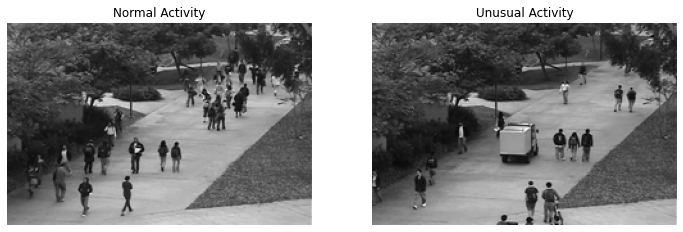

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(plt.imread(path+'/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004/001.tif'), cmap='gray')
ax[0].set_title('Normal Activity')
ax[0].axis('off')
ax[1].imshow(plt.imread(path+'/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014/177.tif'), cmap='gray')
ax[1].set_title('Unusual Activity')
ax[1].axis('off')
plt.show()

In [ ]:
class UCSDPedTrain(torch.utils.data.Dataset):
  def __init__(self, path):
    generate_dataset(path)
    ped1 = h5py.File(os.path.join(path, 'ucsdped1.h5'), 'r')
    ped2 = h5py.File(os.path.join(path, 'ucsdped2.h5'), 'r')
    self.dataset = np.concatenate((ped1['train'], ped2['train']), axis=0)
    ped1.close()
    ped2.close()
    self.len = len(self.dataset)
    
    # calcluated using get_stats()
    self.u = 100.54909312221044
    self.std = 50.90340835932827

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    sample = self.dataset[idx].astype(np.float32)
    return self.transform(sample)
  
  def transform(self, x):
    return (x - self.u) / self.std

def get_train_loader(path, batch_size=32):
  dataset = UCSDPedTrain(path)
  return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Convolutional Auto Encoder
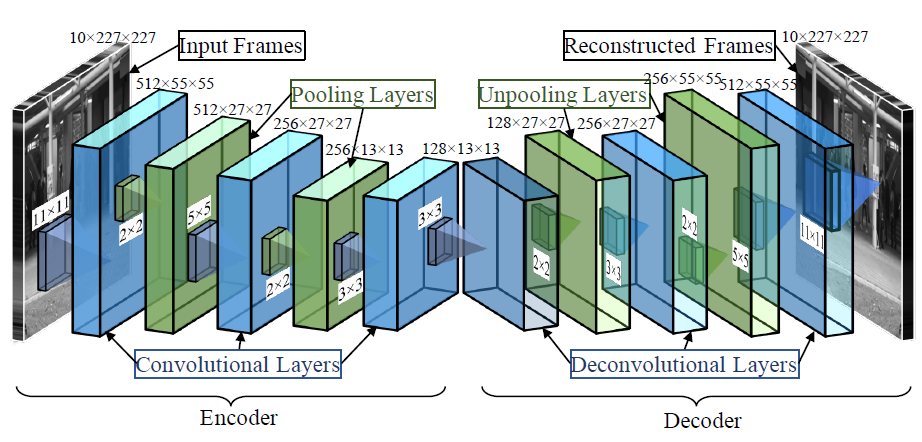

In [6]:
class convSTAE(pl.LightningModule):
  def __init__(self, in_channels=10, lr=1e-2):
    super(convSTAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels, 512, 11, stride=4),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxPool2d(2, return_indices=True),
        nn.BatchNorm2d(512),
        nn.Conv2d(512, 256, 5, padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2, return_indices=True),
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 128, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 256, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxUnpool2d(2),
        nn.BatchNorm2d(256),
        nn.ConvTranspose2d(256, 512, 5, padding=2),
        nn.ReLU(),
        nn.BatchNorm2d(512),
        nn.MaxUnpool2d(2),
        nn.BatchNorm2d(512),
        nn.ConvTranspose2d(512, in_channels, 11, stride=4),
    )
    self.hparams.lr = lr

  def forward(self, input):
    indices = []
    output_sizes = []
    for name, layer in self.encoder.named_children():
      if isinstance(layer, nn.MaxPool2d):
        output_sizes.append(input.shape)
        input, idx = layer(input)
        indices.append(idx)
      else:
        input = layer(input)
      
    i = len(indices) - 1
    for name, layer in self.decoder.named_children():
      if isinstance(layer, nn.MaxUnpool2d):
        input= layer(input, indices[i], output_size=output_sizes[i])
        i -= 1
      else:
        input = layer(input)
    return input
  
  def training_step(self, batch, batch_idx):
        out = self(batch)
        loss = F.mse_loss(out, batch)
        self.log('train_loss', loss)
        return loss

  def configure_optimizers(self):
    optimizer = Adagrad(self.parameters(), lr=self.hparams.lr)
    lr_scheduler = ReduceLROnPlateau(optimizer, patience=8, verbose=True)
    return {
       'optimizer': optimizer,
       'lr_scheduler': lr_scheduler,
       'monitor': 'train_loss'
    }

## Training

In [ ]:
batch_size = 32
train_loader = get_train_loader(path, batch_size)

Dataset ucsdped1.h5 already present
Dataset ucsdped2.h5 already present


In [ ]:
model = convSTAE()
trainer = pl.Trainer(max_epochs=100,
                     gpus=1,
                     auto_select_gpus=True,
                     progress_bar_refresh_rate=20,
                     benchmark=True,
                     callbacks=[
                                EarlyStopping(monitor='train_loss', patience=16, verbose=True),
                                ModelCheckpoint(monitor='train_loss', mode='min', verbose=True)],
                     default_root_dir=path
                     )

EarlyStopping mode set to min for monitoring train_loss.
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model, train_loader)


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 4.2 M 
1 | decoder | Sequential | 4.2 M 
---------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params


Epoch 0, global step 278: train_loss reached 0.25572 (best 0.25572), saving model to "/content/drive/My Drive/uad/lightning_logs/version_3/checkpoints/epoch=0-step=278.ckpt" as top 1
Epoch 1, global step 557: train_loss reached 0.16271 (best 0.16271), saving model to "/content/drive/My Drive/uad/lightning_logs/version_3/checkpoints/epoch=1-step=557.ckpt" as top 1
Epoch 2, step 836: train_loss was not in top 1
Epoch 3, global step 1115: train_loss reached 0.12151 (best 0.12151), saving model to "/content/drive/My Drive/uad/lightning_logs/version_3/checkpoints/epoch=3-step=1115.ckpt" as top 1
Epoch 4, step 1394: train_loss was not in top 1
Epoch 5, step 1673: train_loss was not in top 1
Epoch 6, step 1952: train_loss was not in top 1
Epoch 7, global step 2231: train_loss reached 0.09695 (best 0.09695), saving model to "/content/drive/My Drive/uad/lightning_logs/version_3/checkpoints/epoch=7-step=2231.ckpt" as top 1
Epoch 8, global step 2510: train_loss reached 0.09076 (best 0.09076), sav

Epoch    27: reducing learning rate of group 0 to 1.0000e-03.


Epoch 27, step 7811: train_loss was not in top 1
Epoch 28, step 8090: train_loss was not in top 1
Epoch 29, step 8369: train_loss was not in top 1
Epoch 30, step 8648: train_loss was not in top 1
Epoch 31, step 8927: train_loss was not in top 1
Epoch 32, step 9206: train_loss was not in top 1
Epoch 33, step 9485: train_loss was not in top 1


1

## Testing & Metric calculation

In [7]:
# load best model
model = convSTAE()
model.load_from_checkpoint(os.path.join(path, "./lightning_logs/version_3/checkpoints/epoch=17-step=5021.ckpt"))

convSTAE(
  (encoder): Sequential(
    (0): Conv2d(10, 512, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(512, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(3, 

### Loss calculation of test clips
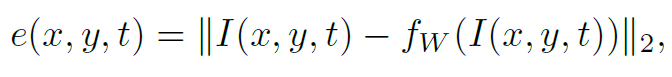

In [ ]:
if torch.cuda.is_available():
  model = model.cuda()
test_folders = sorted([f for f in glob.glob(path+'/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test*') if f[-1] != 't'])
loss = []
model.eval()

for i, folder in enumerate(test_folders, 1):
  print('\r', i, '/36',end='')
  files = sorted(glob.glob(folder+'/*.tif'))
  closs = []
  for i in range(len(files)-9):
    x = np.zeros((10, 227, 227), dtype=np.float32)
    for j in range(10):
      im = Image.open(files[i+j])
      try:
        im = im.resize((227, 227))
        x[j, :, :] = np.array(im, dtype=np.float32)/255.0
      except OSError:
        x[j, :, :] = np.zeros((227, 227), dtype=np.float32)
    x = torch.from_numpy(x).reshape(1, *x.shape)
    if torch.cuda.is_available():
      x = x.cuda()
    y = model(x)
    l = float(F.mse_loss(y, x))
    closs.append(l)
  loss.append(closs)
loss = np.array(loss)

# saving for future reference
np.save(os.path.join(path, 'loss.npy'), loss)

 36 /36

In [8]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

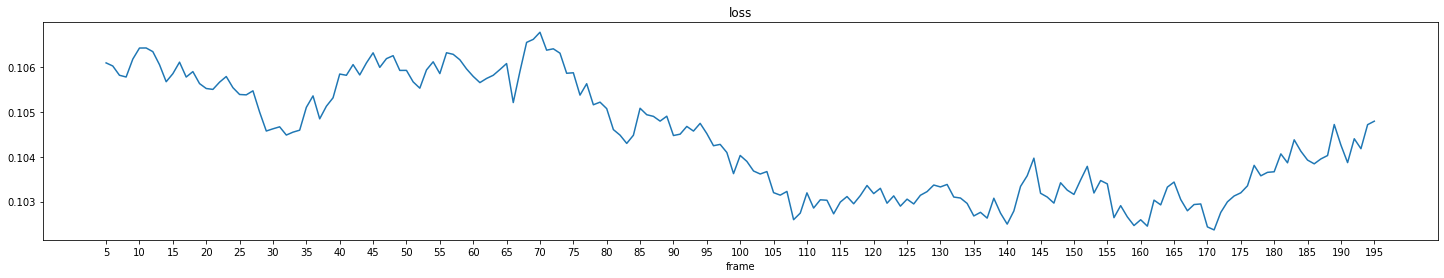

In [81]:
loss = np.load(os.path.join(path, 'loss.npy'))
x = np.arange(5, 196)
ticks = np.arange(5, 196, 5)

# example (test 20)
plt.figure(figsize=(25, 4))
plt.title('loss')
plt.plot(x, loss[20])
plt.xticks(ticks)
plt.xlabel('frame')
plt.show()

### Regularity Calculation
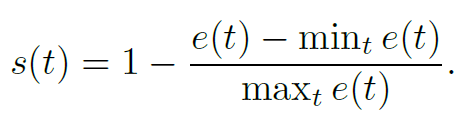

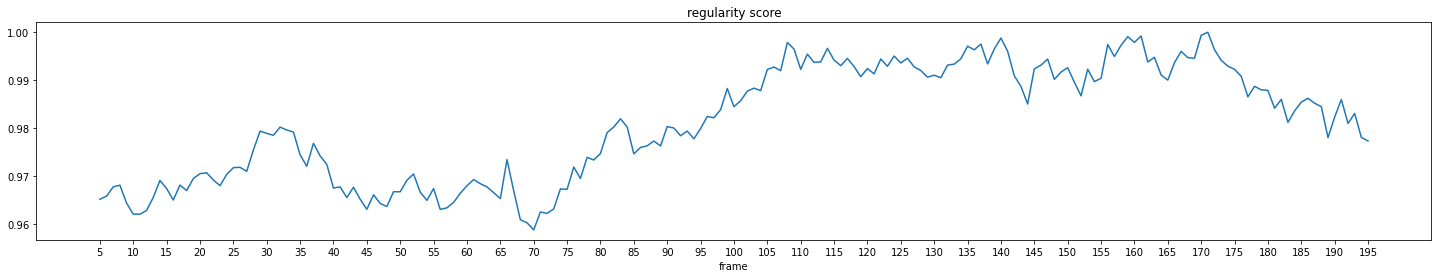

In [82]:
norm_loss = (loss - loss.min(axis=1).reshape((-1, 1)))/loss.max(axis=1).reshape((-1, 1))
regularity = 1-norm_loss
x = np.arange(5, 196)

# example (test 20)
plt.figure(figsize=(25, 4))
plt.title('regularity score')
plt.plot(x, regularity[20])
plt.xticks(ticks)
plt.xlabel('frame')
plt.show()

### Abnormality Detection

#### Dowloading and importing [persistance1d](https://www.csc.kth.se/~weinkauf/notes/persistence1d.html)
RunPersistence gives us local extemes and their persistance(a value indicating for how long period this number is an extema).<br>
This is used to select useful minimas from noisy data.

In [11]:
!curl -o persistence1d.py https://raw.githubusercontent.com/weinkauf/Persistence1D/master/python/persistence1d.py
!curl -o unionfind.py https://raw.githubusercontent.com/weinkauf/Persistence1D/master/python/unionfind.py

from persistence1d import RunPersistence

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4193  100  4193    0     0  22303      0 --:--:-- --:--:-- --:--:-- 22303
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5953  100  5953    0     0  43772      0 --:--:-- --:--:-- --:--:-- 43772


#### Metric helper functions to get TP, FP, F1-score

In [12]:
# generated using create_truth (check appendix)
groundTruth = np.load(os.path.join(path, 'groundtruth.npy'))
total = 36 # total abnomal events  in test

def detection(window_size=35, persistance_thres=1e-4, max_num=5):
  '''
  Generates frame level boolean mask for test cases using the regualrity score
  Uses persistance1d algorithm to select local minimas with 
    persistance > persistance_thres
  Flags the frames [minima-window_size:minima+window_size] as abnormal
  returns boolean mask for all the test cases as a matrix of size
    [testcases, totalframes] = [36, 201]
  '''
  mins = []
  for row in regularity:
    # minimas at even index, maxiams at odd index
    m = RunPersistence(row)[0::2]
    m = np.array(m).T
    m = np.where(m[1] > persistance_thres, m[0], 0)
    m = m[m > 0].astype(np.int32)
    m = m[max(len(m)-max_num, 0):]
    mins.append(m)

  abnormal = np.zeros((36, 201))

  for i, m in enumerate(mins):
    for x in m:
      abnormal[i][max(0, x+6-window_size):min(x+6+window_size, 200)] = 1
  return abnormal


def metrics(abnormal, threshold=0.5):
  intersection = abnormal*groundTruth
  correct = intersection.sum(1) / groundTruth.sum(1)
  tp = (correct >= threshold).sum()

  inv = groundTruth == 0
  fa = (abnormal*inv).sum(1) / inv.sum(1)
  fp = ((fa >= threshold) * (correct < threshold)).sum()
  return tp, fp

def f1score(tp, fp, total=40):
  fn = total - tp
  f1 = tp/(tp + 0.5*(fp+fn))
  return f1

#### Detection

In [13]:
window_size = 50          # window of frames to be marked unusual on both sides to selected minimas
threshold = 0.5           # fraction of area overlap with truth to be considered correct detection
persistance_thres = 2e-3  # min persistance value for local minima to be selected
max_num = 2               # max number of minimas to be marked in each test

abnormal = detection(window_size, persistance_thres, max_num)

tp, fp = metrics(abnormal, threshold)

# four cases contains multiple abnormal events, they were manually
# checked if they are being detected correctly or not, hence adding 4
# tp += 4

f1 = f1score(tp, fp)

print('True Positive:', tp)
print('False Positive:', fp)
print('Accuracy:', round(tp/total, 3))
print('F1-Score:', round(f1, 3))

True Positive: 33
False Positive: 2
Accuracy: 0.917
F1-Score: 0.88


## Visualization for Interpretation

In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

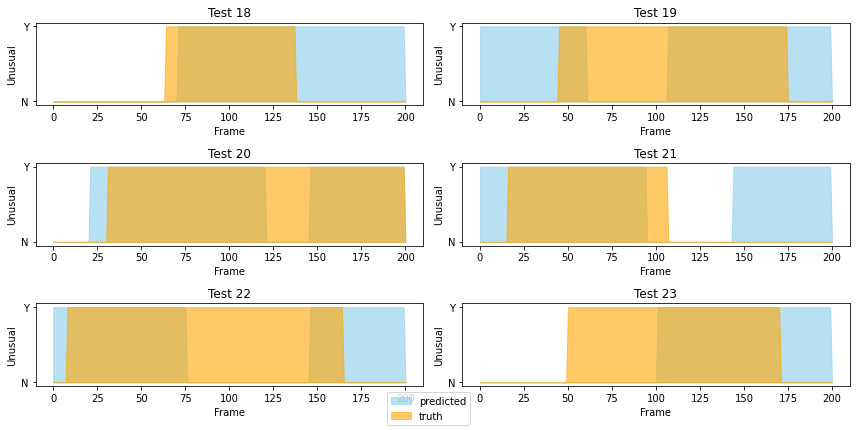

In [84]:
fig, ax = plt.subplots(3, 2, figsize=(12, 6))
for j, i in enumerate(range(18, 24)):
  cax = ax[j//2][j%2]
  cax.fill_between(np.arange(0, 201, 1), abnormal[i], color="skyblue", alpha=0.6, label='predicted')
  cax.fill_between(np.arange(0, 201, 1), groundTruth[i], color="orange", alpha=0.6, label='truth')
  cax.set_yticks([0, 1])
  cax.set_yticklabels(['N', 'Y'])
  cax.set_ylabel('Unusual')
  cax.set_xlabel('Frame')
  cax.set_title('Test {}'.format(i))
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
fig.tight_layout()
plt.show()

In [85]:
def plot_test(i):
  m = RunPersistence(regularity[i])[0::2]
  m = np.array(m).T
  m = np.where(m[1] > persistance_thres, m[0], 0)
  m = m[m > 0].astype(np.int32)
  m = m[max(len(m)-max_num, 0):]
  
  plt.figure(figsize=(25, 4))
  plt.title('regularity score')
  x = np.arange(5, 196)
  plt.plot(x, regularity[20])
  x = np.arange(0, 201, 1)
  plt.fill_between(x, abnormal[i], color="skyblue", alpha=0.4, label='detected')
  plt.fill_between(x, groundTruth[i], color="orange", alpha=0.2, label='ground truth')
  plt.scatter(m+5, regularity[i][m], color='red', label='minimas')
  plt.xticks(ticks)
  plt.xlabel('frame')
  plt.legend()
  plt.show()

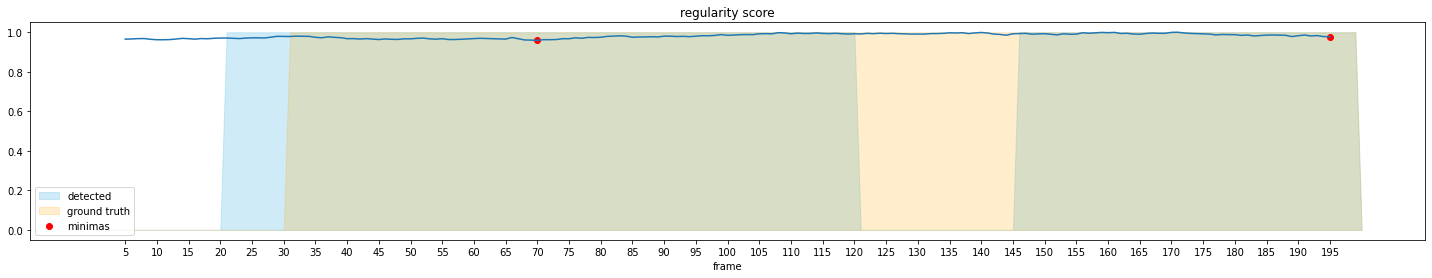

In [87]:
plot_test(20)

In [55]:
u = 100.54909312221044
std = 50.90340835932827
transform = lambda x: ((x-u)/std).astype(np.float32)
invtrans = lambda x: (x*std + u).astype(np.uint8)
normalise = lambda x: (x - x.min())/x.max()

In [45]:
with h5py.File(os.path.join(path, 'ucsdped1.h5'), 'r') as f:
  x = f['test']['test35'][87]
x_trans = transform(x)
y = model(torch.from_numpy(x_trans.reshape(1, *x_trans.shape)))
y = y.reshape(y.shape[1:]).detach().numpy()
diff = np.abs(x_trans-y)

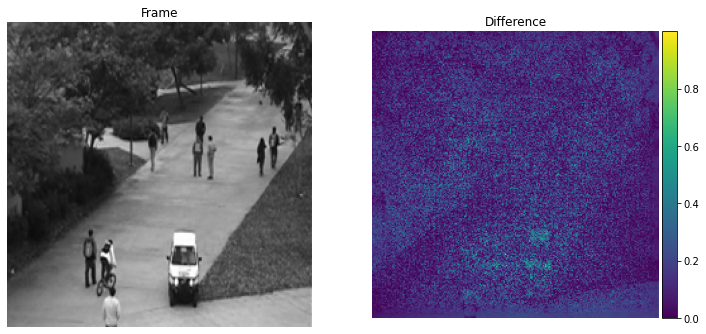

In [78]:
i = 5

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(x[i], cmap='gray')
ax[0].set_title('Frame')
ax[0].axis('off')

im1 = ax[1].imshow(normalise(diff[i]))
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical');
ax[1].set_title('Difference')
ax[1].axis('off')

plt.show()

## Appendix

In [ ]:
def create_truth(savepath):
  # Ported UCSDped1.m to python
  groundTruth = np.zeros((36, 201))
  groundTruth[0][60:152] = 1
  groundTruth[1][50:175] = 1
  groundTruth[2][91:200] = 1
  groundTruth[3][31:168] = 1
  groundTruth[4][5:90] = 1
  groundTruth[4][140:200] = 1
  groundTruth[5][1:100] = 1
  groundTruth[5][110:200] = 1
  groundTruth[6][1:175] = 1
  groundTruth[7][1:94] = 1
  groundTruth[8][1:48] = 1
  groundTruth[9][1:140] = 1
  groundTruth[10][70:165] = 1
  groundTruth[11][130:200] = 1
  groundTruth[12][1:156] = 1
  groundTruth[13][1:200] = 1
  groundTruth[14][138:200] = 1
  groundTruth[15][123:200] = 1
  groundTruth[16][1:47] = 1
  groundTruth[17][54:120] = 1
  groundTruth[18][64:138] = 1
  groundTruth[19][45:175] = 1
  groundTruth[20][31:200] = 1
  groundTruth[21][16:107] = 1
  groundTruth[22][8:165] = 1
  groundTruth[23][50:171] = 1
  groundTruth[24][40:135] = 1
  groundTruth[25][77:144] = 1
  groundTruth[26][10:122] = 1
  groundTruth[27][105:200] = 1
  groundTruth[28][1:15] = 1
  groundTruth[28][45:113] = 1
  groundTruth[29][175:200] = 1
  groundTruth[30][1:180] = 1
  groundTruth[31][1:52] = 1
  groundTruth[31][65:115] = 1
  groundTruth[32][5:165] = 1
  groundTruth[33][1:121] = 1
  groundTruth[34][86:200] = 1
  groundTruth[35][15:108] = 1
  np.save(savepath, groundTruth)

create_truth(os.path.join(path,'groundtruth.npy'))